In [1]:
import os
import math
import time

from contextlib import contextmanager
import numpy as np
import pandas as pd
from IPython.display import display
import lightgbm
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [3]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(12, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('../output/lgbm_importances_bayesian.png')

In [4]:
def kfold_lightgbm(df, num_folds, stratified = False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    
    # Add PCA dimensions
    test_df = test_df.reset_index()
    test_df = test_df.drop('index', axis = 1)
    
    train_x_reduced = pd.read_csv('../data/application_train_pca.csv')
    test_x_reduced = pd.read_csv('../data/application_test_pca.csv')
    train_x_reduced = train_x_reduced.drop('Unnamed: 0', axis = 1)
    test_x_reduced = test_x_reduced.drop('Unnamed: 0', axis = 1)
    
    train_df = pd.concat([train_df, train_x_reduced], axis = 1)
    test_df = pd.concat([test_df, test_x_reduced], axis = 1)
    
    
    cat_cols = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
                'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
                'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 
                'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
                'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
                'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_11', 
                'FLAG_DOCUMENT_18', 'CODE_GENDER', 'NAME_CONTRACT_TYPE',
                'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'EMERGENCYSTATE_MODE',
                'HOUSETYPE_MODE', 'FONDKAPREMONT_MODE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                'NAME_HOUSING_TYPE', 'NAME_TYPE_SUITE', 'WALLSMATERIAL_MODE','WEEKDAY_APPR_PROCESS_START',
                'NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'TARGET']
    
    included_cat_cols = [i for i in cat_cols if i in list(train_df.columns)]
    
#     df_static = df.iloc[:,:144]
#     num_cols = [x for x in list(df_static.columns) if x not in included_cat_cols]
#     train_df = train_df.drop(num_cols, axis = 1)
#     test_df = test_df.drop(num_cols, axis = 1)
    
    included_cat_cols.remove('TARGET')
    
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df, cat_cols, train_x_reduced, test_x_reduced#, df_static, num_cols
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        dtrain = lightgbm.Dataset(data=train_df[feats].iloc[train_idx], 
                             label=train_df['TARGET'].iloc[train_idx], 
                             free_raw_data=False, silent=True,
                             categorical_feature=included_cat_cols)
        dvalid = lightgbm.Dataset(data=train_df[feats].iloc[valid_idx], 
                             label=train_df['TARGET'].iloc[valid_idx], 
                             free_raw_data=False, silent=True,
                             categorical_feature=included_cat_cols)

        # LightGBM parameters found by Bayesian optimization
        params = {
            'objective': 'binary',
            'boosting_type': 'gbdt', # 'goss'
            'nthread': 4,
            'learning_rate': 0.02,  # 02,
            'num_leaves': 20,
            'colsample_bytree': 0.9497036,
            'subsample': 0.8715623,
            'subsample_freq': 1,
            'max_depth': 8,
            'reg_alpha': 0.041545473,
            'reg_lambda': 0.0735294,
            'min_split_gain': 0.0222415,
            'min_child_weight': 39.3259775, # 60
            'seed': 0,
            'verbose': -1,
            'metric': 'auc',
        }

        clf = lightgbm.train(
            params=params,
            train_set=dtrain,
            num_boost_round=10000,
            valid_sets=[dtrain, dvalid],
            early_stopping_rounds= 200,
            verbose_eval=100
        )

        oof_preds[valid_idx] = clf.predict(dvalid.data)
        sub_preds += clf.predict(test_df[feats]) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(dvalid.label, oof_preds[valid_idx])))
        del clf, dtrain, dvalid

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    sub_df = test_df[['SK_ID_CURR']].copy()
    sub_df['TARGET'] = sub_preds
    sub_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

Starting LightGBM. Train shape: (307511, 671), test shape: (48744, 671)


/anaconda3/envs/home-credit/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda3/envs/home-credit/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.767098	valid_1's auc: 0.757635
[200]	training's auc: 0.787851	valid_1's auc: 0.773437
[300]	training's auc: 0.800024	valid_1's auc: 0.780954
[400]	training's auc: 0.80882	valid_1's auc: 0.784986
[500]	training's auc: 0.816428	valid_1's auc: 0.787661
[600]	training's auc: 0.822979	valid_1's auc: 0.789298
[700]	training's auc: 0.829117	valid_1's auc: 0.79022
[800]	training's auc: 0.834606	valid_1's auc: 0.791005
[900]	training's auc: 0.839798	valid_1's auc: 0.791507
[1000]	training's auc: 0.844796	valid_1's auc: 0.791847
[1100]	training's auc: 0.84937	valid_1's auc: 0.792149
[1200]	training's auc: 0.853898	valid_1's auc: 0.792497
[1300]	training's auc: 0.858139	valid_1's auc: 0.792785
[1400]	training's auc: 0.862194	valid_1's auc: 0.792995
[1500]	training's auc: 0.866289	valid_1's auc: 0.79314
[1600]	training's auc: 0.870141	valid_1's auc: 0.793137
[1700]	training's auc: 0.873858	valid_1's auc: 0.79309

/anaconda3/envs/home-credit/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda3/envs/home-credit/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.766534	valid_1's auc: 0.75573
[200]	training's auc: 0.787563	valid_1's auc: 0.773268
[300]	training's auc: 0.799798	valid_1's auc: 0.78043
[400]	training's auc: 0.808604	valid_1's auc: 0.784735
[500]	training's auc: 0.816123	valid_1's auc: 0.787418
[600]	training's auc: 0.823016	valid_1's auc: 0.789038
[700]	training's auc: 0.829231	valid_1's auc: 0.790133
[800]	training's auc: 0.834847	valid_1's auc: 0.790954
[900]	training's auc: 0.839961	valid_1's auc: 0.791464
[1000]	training's auc: 0.844788	valid_1's auc: 0.791888
[1100]	training's auc: 0.849456	valid_1's auc: 0.792169
[1200]	training's auc: 0.853843	valid_1's auc: 0.79251
[1300]	training's auc: 0.858088	valid_1's auc: 0.792779
[1400]	training's auc: 0.862146	valid_1's auc: 0.792917
[1500]	training's auc: 0.866012	valid_1's auc: 0.79306
[1600]	training's auc: 0.870039	valid_1's auc: 0.793241
[1700]	training's auc: 0.873916	valid_1's auc: 0.79334

/anaconda3/envs/home-credit/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda3/envs/home-credit/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.76767	valid_1's auc: 0.751259
[200]	training's auc: 0.7891	valid_1's auc: 0.767441
[300]	training's auc: 0.801313	valid_1's auc: 0.774533
[400]	training's auc: 0.810189	valid_1's auc: 0.778576
[500]	training's auc: 0.817499	valid_1's auc: 0.78075
[600]	training's auc: 0.824046	valid_1's auc: 0.782553
[700]	training's auc: 0.830141	valid_1's auc: 0.783753
[800]	training's auc: 0.835705	valid_1's auc: 0.784594
[900]	training's auc: 0.840747	valid_1's auc: 0.78518
[1000]	training's auc: 0.845607	valid_1's auc: 0.785436
[1100]	training's auc: 0.850182	valid_1's auc: 0.785811
[1200]	training's auc: 0.854672	valid_1's auc: 0.786137
[1300]	training's auc: 0.858938	valid_1's auc: 0.786568
[1400]	training's auc: 0.863019	valid_1's auc: 0.786758
[1500]	training's auc: 0.866844	valid_1's auc: 0.7868
[1600]	training's auc: 0.870833	valid_1's auc: 0.786859
[1700]	training's auc: 0.874574	valid_1's auc: 0.787036
[

/anaconda3/envs/home-credit/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda3/envs/home-credit/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.767585	valid_1's auc: 0.756688
[200]	training's auc: 0.788797	valid_1's auc: 0.771322
[300]	training's auc: 0.801045	valid_1's auc: 0.777899
[400]	training's auc: 0.810171	valid_1's auc: 0.781873
[500]	training's auc: 0.81779	valid_1's auc: 0.784135
[600]	training's auc: 0.824354	valid_1's auc: 0.78562
[700]	training's auc: 0.830358	valid_1's auc: 0.786431
[800]	training's auc: 0.835896	valid_1's auc: 0.787273
[900]	training's auc: 0.841104	valid_1's auc: 0.787993
[1000]	training's auc: 0.846027	valid_1's auc: 0.788486
[1100]	training's auc: 0.85059	valid_1's auc: 0.788685
[1200]	training's auc: 0.855085	valid_1's auc: 0.788854
[1300]	training's auc: 0.859287	valid_1's auc: 0.789062
[1400]	training's auc: 0.863297	valid_1's auc: 0.789341
[1500]	training's auc: 0.867224	valid_1's auc: 0.789562
[1600]	training's auc: 0.87109	valid_1's auc: 0.789534
[1700]	training's auc: 0.874882	valid_1's auc: 0.78956

/anaconda3/envs/home-credit/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda3/envs/home-credit/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.766988	valid_1's auc: 0.759604
[200]	training's auc: 0.787746	valid_1's auc: 0.7744
[300]	training's auc: 0.800026	valid_1's auc: 0.781186
[400]	training's auc: 0.809201	valid_1's auc: 0.785051
[500]	training's auc: 0.816885	valid_1's auc: 0.78735
[600]	training's auc: 0.823695	valid_1's auc: 0.788729
[700]	training's auc: 0.829707	valid_1's auc: 0.789685
[800]	training's auc: 0.835187	valid_1's auc: 0.790483
[900]	training's auc: 0.840363	valid_1's auc: 0.790926
[1000]	training's auc: 0.84523	valid_1's auc: 0.791315
[1100]	training's auc: 0.849775	valid_1's auc: 0.791539
[1200]	training's auc: 0.854194	valid_1's auc: 0.791701
[1300]	training's auc: 0.858438	valid_1's auc: 0.791851
[1400]	training's auc: 0.862681	valid_1's auc: 0.792133
[1500]	training's auc: 0.866699	valid_1's auc: 0.792257
[1600]	training's auc: 0.870517	valid_1's auc: 0.792268
[1700]	training's auc: 0.87422	valid_1's auc: 0.792437

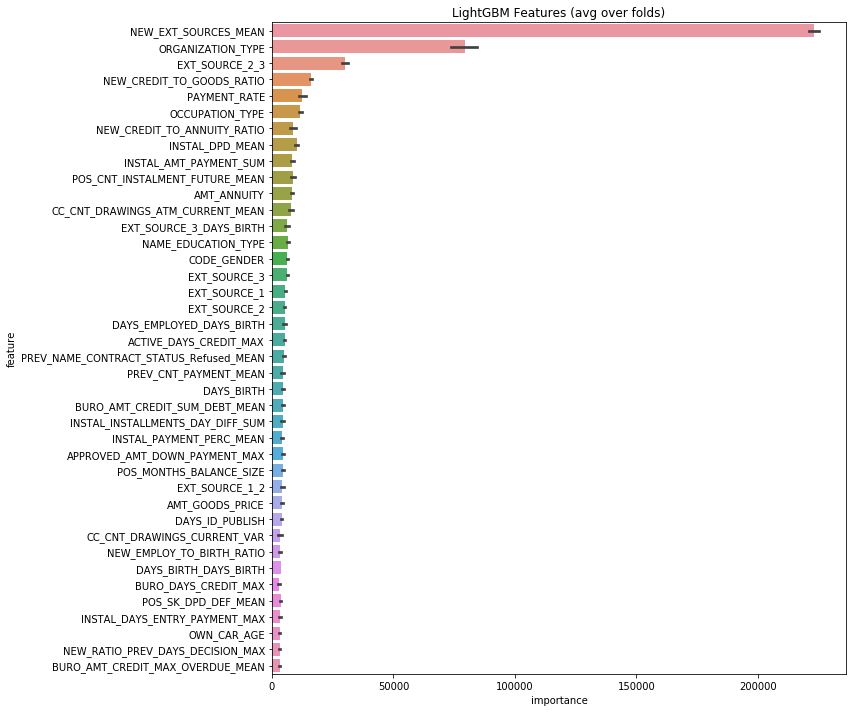

In [5]:
def main():
    
    df = pd.read_csv('../data/processed_data_2.5_pca.csv')
    df = df.drop('Unnamed: 0', axis = 1)
    
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 5, stratified = False) 
        
    return feat_importance


if __name__ == "__main__":
    submission_file_name = "../predictions/lightgbm_pred_pca.csv"
    with timer("Full model run"):
        feat_importance = main()
        importance_df = feat_importance.groupby('feature').agg('mean').drop('fold', axis = 1).sort_values('importance')
        importance_df.to_csv('../output/importance_pca.csv')